In [122]:
import pandas as pd
from pandasql import sqldf
import seaborn as sns
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

p = 'C:/Users/15714/Documents/homework/2022 Fall/DAEN 690/Project Docs/data_providers/tagged_data_28-11-2022_23_36_15.csv'
df = pd.read_csv(p).drop('Unnamed: 0', axis =1)
extd_df = pd.read_csv('../data/EXPANDED_acled_covid19.csv')

In [83]:
sqldf('''
    SELECT count(DISTINCT source_singular_main)
    FROM df
    WHERE country IS NOT NULL
    AND sub_event_type IS NOT NULL
''', globals())

,count(DISTINCT source_singular_main)
0,1661


In [84]:
sqldf('''
    SELECT count(DISTINCT source_singular_main)
    FROM df
    WHERE country IS NULL
    AND sub_event_type IS NULL
''', globals())

,count(DISTINCT source_singular_main)
0,2342


In [85]:
sqldf('''
    SELECT count(DISTINCT source_singular_main)
    FROM df
    WHERE country IS NOT NULL
    AND sub_event_type IS NULL
''', globals())

,count(DISTINCT source_singular_main)
0,1311


In [86]:
sqldf('''
    SELECT count(DISTINCT source_singular_main)
    FROM df
    WHERE country IS NULL
    AND sub_event_type IS NOT NULL
''', globals())

,count(DISTINCT source_singular_main)
0,52


In [87]:
sqldf('''
    SELECT count(DISTINCT source_singular_main)
    FROM df
    WHERE sub_event_type IS NOT NULL
''', globals())

,count(DISTINCT source_singular_main)
0,1713


In [88]:
sqldf('''
    SELECT count(DISTINCT source_singular_main)
    FROM df
    WHERE country IS NOT NULL
''', globals())

,count(DISTINCT source_singular_main)
0,2972


In [89]:
def _clean(c):
    for r in [' ', '-', '/']:
        c = c.replace(r, '_')
    
    for r in ['.', ',']:
        c = c.replace(r, '')
    
    return c

cty = sqldf('''
    SELECT DISTINCT source_singular, country
    FROM df
    WHERE country IS NOT NULL
''', globals())

cty['country'] = cty['country'].str.replace('_majority','')
cty['country_cln'] = [_clean(c) for c in cty['country']]

evt = sqldf('''
    SELECT DISTINCT source_singular, sub_event_type
    FROM df
    WHERE sub_event_type IS NOT NULL
''', globals())

evt['sub_event_type'] = evt['sub_event_type'].str.replace('_majority','')
evt['sub_event_type_cln'] = [_clean(c) for c in evt['sub_event_type']]

In [152]:
cty_notin = [c for c in list(set(extd_df['country'])) if _clean(c) not in list(cty['country_cln'])]
cty_in = [c for c in list(set(extd_df['country'])) if _clean(c) in list(cty['country_cln'])]
print(len(cty_notin))
print(len(cty_in))
cty_in = list(map(lambda x: x.replace('United States', 'United States of America'), cty_in))
cty_notin.sort()
cty_in.sort()
cty_in
x = list(countries['name'])
x.sort
cty_notin

51
169


['Anguilla',
 'Antigua and Barbuda',
 'Aruba',
 'Bailiwick of Guernsey',
 'Bailiwick of Jersey',
 'Bhutan',
 'Brunei',
 'Caribbean Netherlands',
 'Cayman Islands',
 'Cook Islands',
 'Curacao',
 'Djibouti',
 'Dominica',
 'Equatorial Guinea',
 'Eritrea',
 'Falkland Islands',
 'French Guiana',
 'Gibraltar',
 'Guadeloupe',
 'Guinea-Bissau',
 'Isle of Man',
 'Laos',
 'Lesotho',
 'Martinique',
 'Monaco',
 'Montserrat',
 'Nauru',
 'Nicaragua',
 'Northern Mariana Islands',
 'Oman',
 'Qatar',
 'Saint Helena, Ascension and Tristan da Cunha',
 'Saint Kitts and Nevis',
 'Saint Vincent and the Grenadines',
 'Saint-Barthelemy',
 'Samoa',
 'San Marino',
 'Saudi Arabia',
 'Singapore',
 'Sint Maarten',
 'Somalia',
 'South Sudan',
 'Tajikistan',
 'Tanzania',
 'Tonga',
 'Turkmenistan',
 'Turks and Caicos Islands',
 'United Arab Emirates',
 'Vanuatu',
 'Virgin Islands, U.S.',
 'Zambia']

<AxesSubplot:>

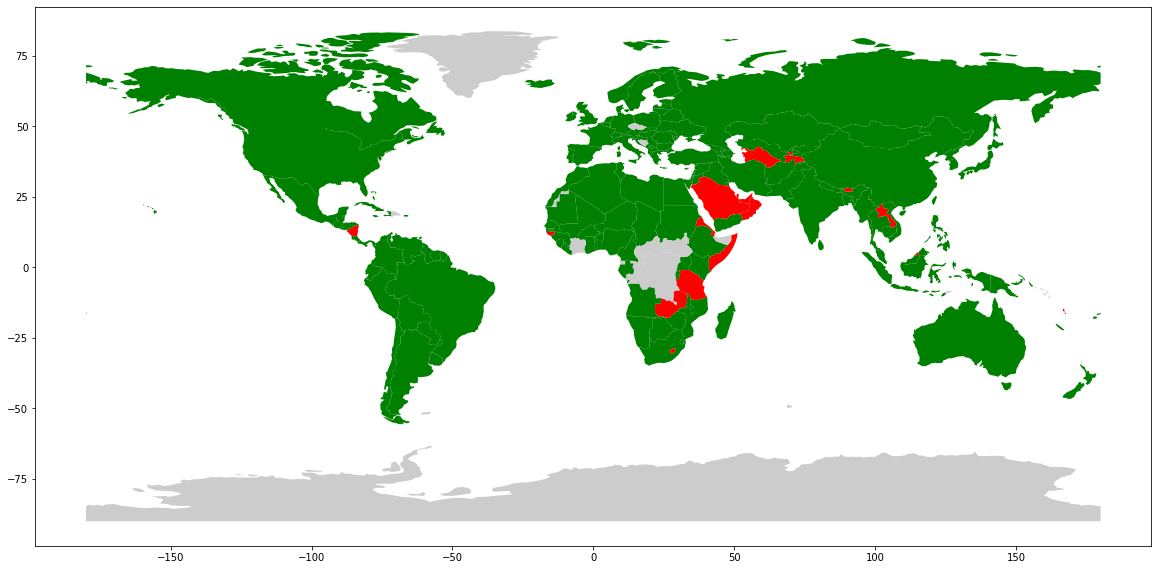

In [150]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

not_tagged = np.where(countries['name'].isin(cty_notin), 'r', np.where(countries['name'].isin(cty_in), 'g', '0.8'))

fig, ax = plt.subplots(figsize=(20,20))

countries.plot(color=not_tagged, ax=ax)

In [97]:
evt_notin = [c for c in list(set(extd_df['sub_event_type'])) if _clean(c) not in list(evt['sub_event_type_cln'])]
len(evt_notin)

9

<AxesSubplot:title={'center':'Tag Value Percent Threshold vs. Total Unique Countries Tagged'}, xlabel='Minimum Percent of Tag Value Per Source', ylabel='Total Countries'>

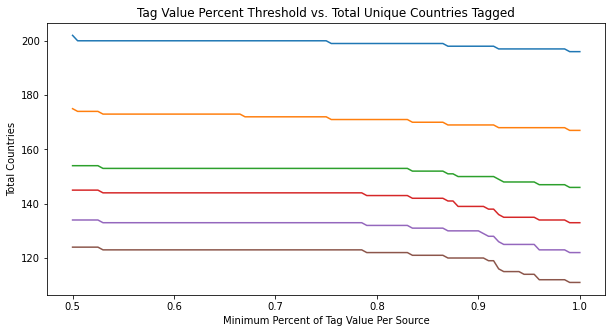

In [153]:
cnt_df = sqldf('''
    SELECT a.source_singular, a.country, cnt, cast(total as int) total, cast(cast(cnt as double)/cast(total as double) as double) pct FROM
        (SELECT source_singular, country, count(*) cnt FROM extd_df GROUP BY source_singular, country) a
        JOIN (SELECT source_singular, count(*) total FROM extd_df GROUP BY source_singular) b
        ON a.source_singular = b.source_singular
''', globals())

def _newdf(cnt_min):
    pcts = np.linspace(0.5,1,101)
    newdf = pd.DataFrame()

    newdf['pcts'] = pcts
    cond = (cnt_df['total'] > cnt_min)
    newdf['cnt'] = [len(list(set(cnt_df[(cnt_df['pct'] >= p) & cond]['country']))) for p in pcts]
    
    return newdf


fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f'Tag Value Percent Threshold vs. Total Unique Countries Tagged')
ax.set(xlabel='Minimum Percent of Tag Value Per Source', ylabel='Total Countries')

df0 = _newdf(0)
sns.lineplot(data=df0, x=df0['pcts'], y=df0['cnt'], ax=ax)

df2 = _newdf(2)
sns.lineplot(data=df2, x=df2['pcts'], y=df2['cnt'], ax=ax)

df4 = _newdf(4)
sns.lineplot(data=df4, x=df4['pcts'], y=df4['cnt'], ax=ax)

df6 = _newdf(6)
sns.lineplot(data=df6, x=df6['pcts'], y=df6['cnt'], ax=ax)

df8 = _newdf(8)
sns.lineplot(data=df8, x=df8['pcts'], y=df8['cnt'], ax=ax)

df10 = _newdf(10)
sns.lineplot(data=df10, x=df10['pcts'], y=df10['cnt'], ax=ax)

<AxesSubplot:title={'center':'Tag Value Percent Threshold vs. Total Unique Event Types Tagged'}, xlabel='Minimum Percent of Tag Value Per Source', ylabel='Total Event Types'>

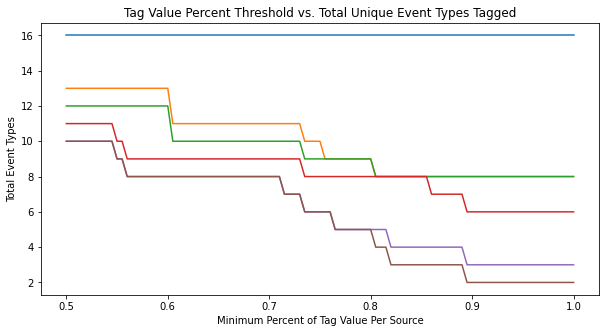

In [154]:
cnt_df = sqldf('''
    SELECT a.source_singular, a.sub_event_type, cnt, cast(total as int) total, cast(cast(cnt as double)/cast(total as double) as double) pct FROM
        (SELECT source_singular, sub_event_type, count(*) cnt FROM extd_df GROUP BY source_singular, sub_event_type) a
        JOIN (SELECT source_singular, count(*) total FROM extd_df GROUP BY source_singular) b
        ON a.source_singular = b.source_singular
''', globals())

def _newdf(cnt_min):
    pcts = np.linspace(0.5,1,101)
    newdf = pd.DataFrame()

    newdf['pcts'] = pcts
    cond = (cnt_df['total'] > cnt_min)
    newdf['cnt'] = [len(list(set(cnt_df[(cnt_df['pct'] >= p) & cond]['sub_event_type']))) for p in pcts]
    
    return newdf


fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f'Tag Value Percent Threshold vs. Total Unique Event Types Tagged')
ax.set(xlabel='Minimum Percent of Tag Value Per Source', ylabel='Total Event Types')

df0 = _newdf(0)
sns.lineplot(data=df0, x=df0['pcts'], y=df0['cnt'], ax=ax)

df2 = _newdf(2)
sns.lineplot(data=df2, x=df2['pcts'], y=df2['cnt'], ax=ax)

df4 = _newdf(4)
sns.lineplot(data=df4, x=df4['pcts'], y=df4['cnt'], ax=ax)

df6 = _newdf(6)
sns.lineplot(data=df6, x=df6['pcts'], y=df6['cnt'], ax=ax)

df8 = _newdf(8)
sns.lineplot(data=df8, x=df8['pcts'], y=df8['cnt'], ax=ax)

df0 = _newdf(10)
sns.lineplot(data=df0, x=df0['pcts'], y=df0['cnt'], ax=ax)

In [173]:
sample_tagged = sqldf('''
    SELECT source_singular_main `Source Name`, country Country, sub_event_type `Event Type`
    FROM df
    WHERE source_singular_main IN ('Ahmedabad Mirror', 'OpIndia','India Blooms News Service','Haderi Ha Haredeem','Amar Ujala','Indian Express','Siliguri Times')
    ORDER BY country DESC, sub_event_type DESC
''', globals())

sample_tagged['Source URL'] = sample_tagged['Source Name'].apply(lambda x: x.replace(' ', ''))
sample_tagged['Source URL'] = sample_tagged['Source URL'].astype(str) + '.com'

cols = sample_tagged.columns.tolist()
cols = cols[-1:] + cols[:-1]

sample_tagged = sample_tagged[cols]

sample_tagged.to_csv('sample_tagged.csv')

sample_tagged

,Source URL,Source Name,Country,Event Type
0,OpIndia.com,OpIndia,India_majority,Mob_violence_majority
1,AhmedabadMirror.com,Ahmedabad Mirror,India_majority,Mob_violence_majority
2,AmarUjala.com,Amar Ujala,India_majority,None
3,IndianExpress.com,Indian Express,India_majority,None
4,SiliguriTimes.com,Siliguri Times,India_majority,None
5,HaderiHaHaredeem.com,Haderi Ha Haredeem,None,Mob_violence_majority
6,IndiaBloomsNewsService.com,India Blooms News Service,None,Mob_violence_majority
